In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

In [ ]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves/jupyter_notebooks'

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves'

Model Packages

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Image Shapes Declaration

In [23]:
import joblib
version = 'v6'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape_1.pkl")
image_shape

(100, 100, 3)

In [24]:
import joblib

# Load the class indices from the saved file
class_indices = joblib.load(f"outputs/v7/class_indices.pkl")
train_set='class_indices'

# Print to check
print(class_indices)

{'healthy': 0, 'powdery_mildew': 1}


Model

In [25]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Model Summary

In [26]:
create_tf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 875,777 (3.34 MB)

 Trainable params: 875,777 (3.34 MB)

 Non-trainable params: 0 (0.00 B)

Implementing Early Stopping

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the batch_size
batch_size = 10

# Define train and validation generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    'inputs/leaves_dataset/cherry-leaves/processed_images/train', 
    target_size=(100, 100), 
    batch_size=batch_size, 
    class_mode='binary'
)

validation_set = validation_datagen.flow_from_directory(
    'inputs/leaves_dataset/cherry-leaves/processed_images/validation', 
    target_size=(100, 100), 
    batch_size=batch_size, 
    class_mode='binary'
)

model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

import pandas as pd

# Train the model and capture the history object
history = model.fit(train_set,
                    epochs=25,
                    steps_per_epoch=len(train_set) // batch_size,
                    validation_data=validation_set,
                    validation_steps=len(validation_set) // batch_size,
                    callbacks=[early_stop],
                    verbose=1)

# Convert the history to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('outputs/training_history.csv', index=False)

Found 2944 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Epoch 1/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.7865 - loss: 0.4112 - val_accuracy: 0.9921 - val_loss: 0.0294
Epoch 2/25
  1/294 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 1.0000 - loss: 0.0023

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9921 - val_loss: 0.0292
Epoch 3/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9897 - loss: 0.0358 - val_accuracy: 0.9937 - val_loss: 0.0257
Epoch 4/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9937 - val_loss: 0.0224
Epoch 5/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9940 - loss: 0.0295 - val_accuracy: 0.9952 - val_loss: 0.0188
Epoch 6/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9952 - val_loss: 0.0189
Epoch 7/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9959 - loss: 0.0124 - val_accuracy: 0.9952 - val_loss: 0.0249
Epoch 8/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 3.1193e-04 - val_accuracy: 0.9952 - val_loss: 0.0248
Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 1.0000 - loss: 9.8078e-04 - val_accuracy: 

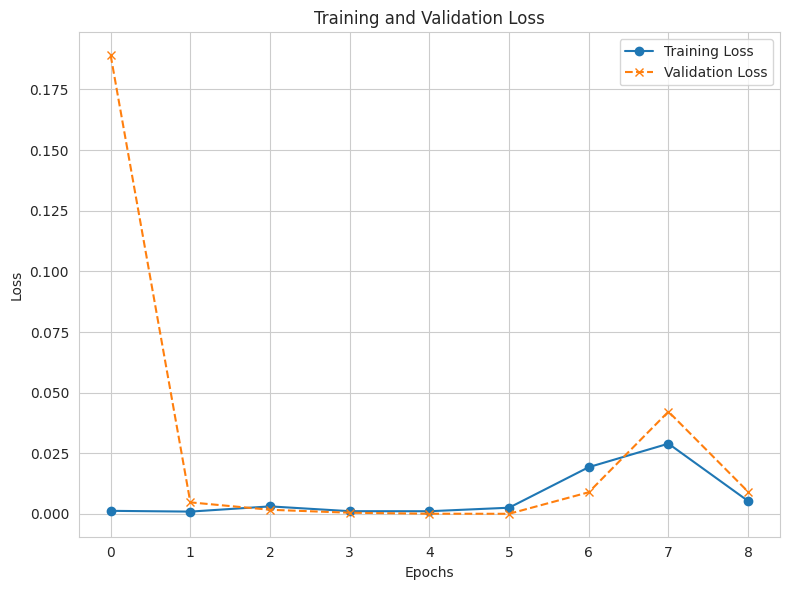

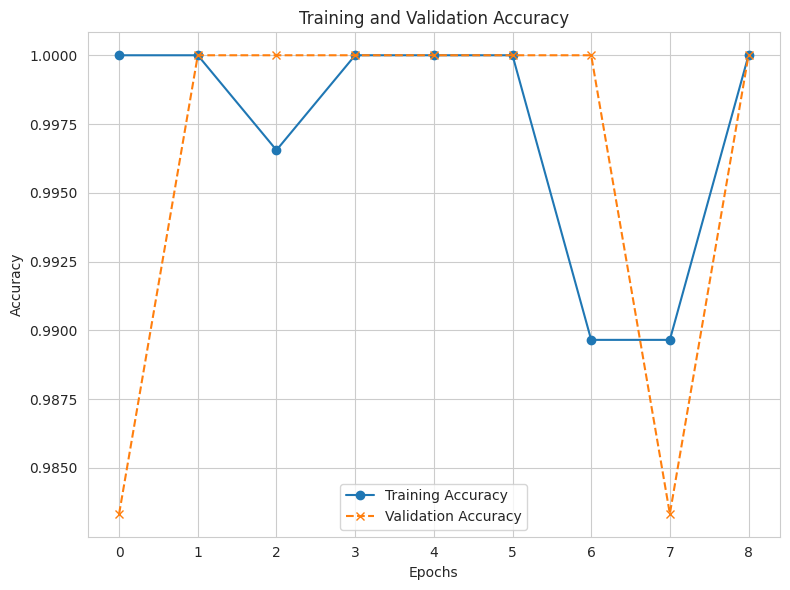

In [34]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a new directory to save the plots, inside 'outputs/v8/'
plots_dir = 'outputs/v8/training_plots'
os.makedirs(plots_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Get the training history
history = model.history.history

# Plot 1: Loss vs. Validation Loss
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.plot(history['loss'], label='Training Loss', linestyle='-', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', linestyle='--', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig(f'{plots_dir}/model_training_loss.png', bbox_inches='tight', dpi=150)
plt.show()

# Plot 2: Accuracy vs. Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='x')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig(f'{plots_dir}/model_training_accuracy.png', bbox_inches='tight', dpi=150)
plt.show()

In [36]:
from keras.models import load_model
model = load_model('outputs/v8/cherry_leaf_model.h5')

In [37]:
# Ensure that the model is compiled before fitting
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now train the model
history = model.fit(train_set,
                    epochs=25,
                    steps_per_epoch=len(train_set) // batch_size,
                    validation_data=validation_set,
                    validation_steps=len(validation_set) // batch_size,
                    callbacks=[early_stop],
                    verbose=1)

# After training, you can access the metrics in the history object
history_df = pd.DataFrame(history.history)
history_df.to_csv('outputs/training_history.csv', index=False)

Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9848 - loss: 0.0528 - val_accuracy: 0.9833 - val_loss: 0.0221
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9821 - loss: 0.0509 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0169
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9885 - loss: 0.0374 - val_accuracy: 0.9833 - val_loss: 0.1064
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9910 - loss: 0.0491 - val_accuracy: 0.9667 - val_loss: 0.0857


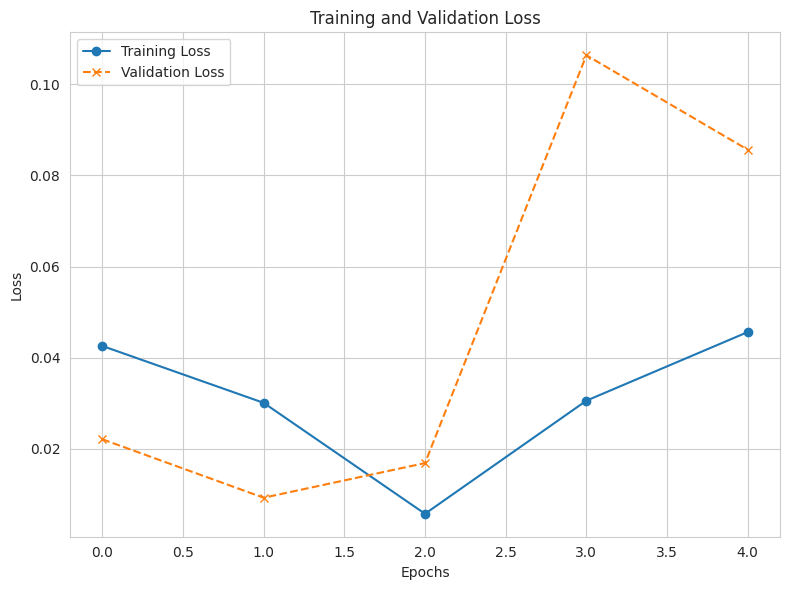

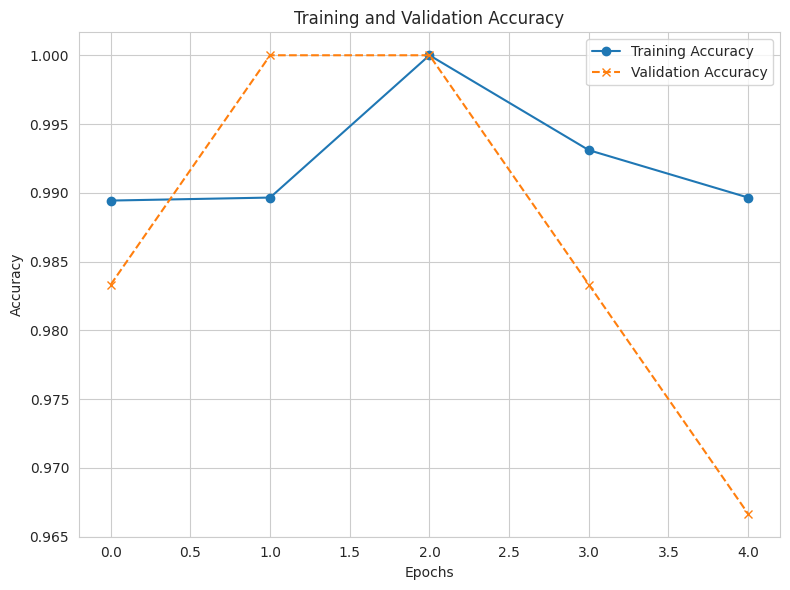

In [38]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract accuracy values (if available)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', linestyle='-', marker='o')
plt.plot(val_loss, label='Validation Loss', linestyle='--', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy', linestyle='-', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', linestyle='--', marker='x')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Evaluate the model on the validation data (or test data if available)
evaluation_metrics = model.evaluate(train_set)  # or use test_set if available

# Output the evaluation result
print(f"Evaluation result: {evaluation_metrics}")

295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9896 - loss: 0.0296
Evaluation result: [0.0306411050260067, 0.9898098111152649]


In [40]:
# Evaluate the model on the validation data (or test data if available)
evaluation_metrics = model.evaluate(validation_set)  # or use test_set if available

# Output the evaluation result
print(f"Evaluation result: {evaluation_metrics}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9734 - loss: 0.0860
Evaluation result: [0.05863618478178978, 0.9809523820877075]


---

preparing model for analysis on testing dataset which the model has not 'seen'.

In [43]:
# Define test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you have a 'test' folder in your dataset structure
test_set = test_datagen.flow_from_directory(
    'inputs/leaves_dataset/cherry-leaves/processed_images/test',
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary'
)

Found 634 images belonging to 2 classes.


In [44]:
# Make predictions on the test set
predictions = model.predict(test_set)

# For binary classification, predictions will output probabilities (e.g., between 0 and 1)
# If you want to get the predicted class labels (0 or 1 for binary classification), you can do:
predicted_classes = (predictions > 0.5).astype("int32")  # Adjust threshold if needed

# For multi-class classification, you can use np.argmax() to get the class with the highest probability
# predicted_classes = np.argmax(predictions, axis=-1)

 4/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [45]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9897 - loss: 0.0437
Test Loss: 0.04484701156616211
Test Accuracy: 0.9905362725257874


In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get true labels from the test set
true_labels = test_set.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report (precision, recall, F1-score)
class_report = classification_report(true_labels, predicted_classes)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[148 169]
 [165 152]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.47      0.47       317
           1       0.47      0.48      0.48       317

    accuracy                           0.47       634
   macro avg       0.47      0.47      0.47       634
weighted avg       0.47      0.47      0.47       634



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


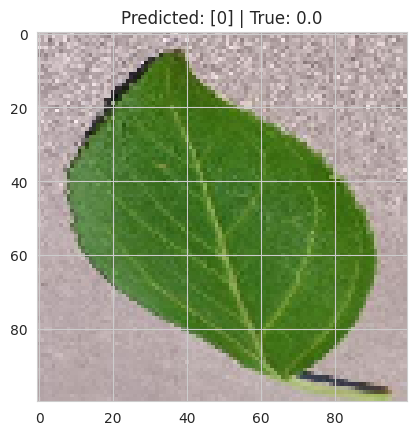

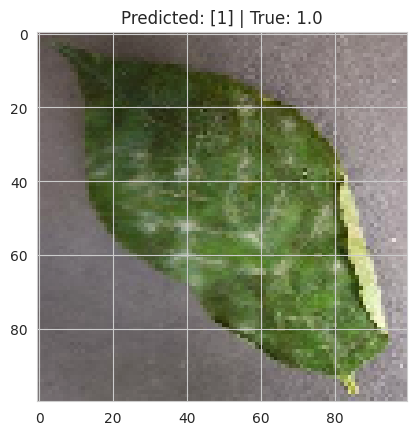

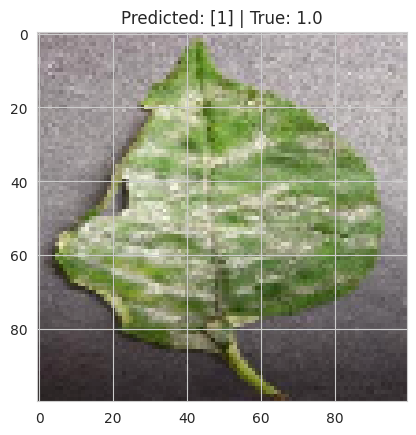

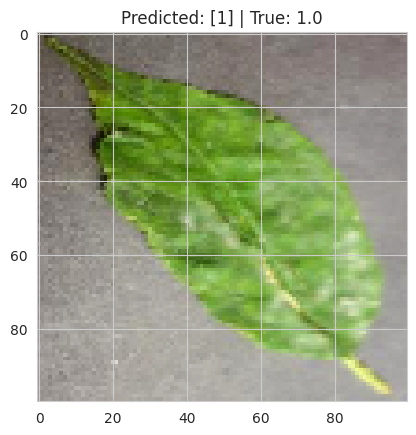

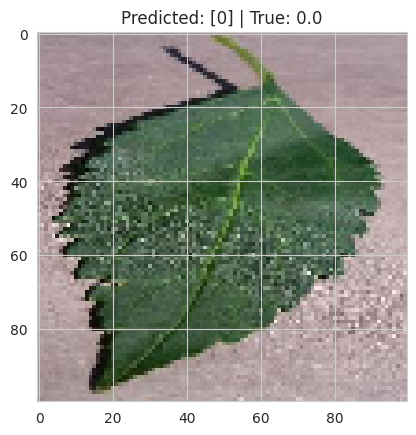

In [50]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(test_set)  # Using next() to get the next batch

# Make predictions for the batch
predictions = model.predict(images)

# Convert predictions to class labels (if binary classification)
predicted_classes = (predictions > 0.5).astype("int32")

# Plot images with predictions
for i in range(5):  # Adjust to display as many images as you want
    plt.imshow(images[i])  # Show the image
    plt.title(f"Predicted: {predicted_classes[i]} | True: {labels[i]}")
    plt.show()

In [51]:
test_evaluation = model.evaluate(test_set)

print(f"Test evaluation result: {test_evaluation}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9949 - loss: 0.0319
Test evaluation result: [0.04484700784087181, 0.9905362725257874]


In [52]:
import pandas as pd

# Prepare the data (can be in a dictionary format)
evaluation_results = {
    'Metric': ['Training Loss', 'Training Accuracy', 'Test Loss', 'Test Accuracy'],
    'Value': [0.0319, 0.9949, 0.0448, 0.9905]
}

# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Save the DataFrame to a CSV file
results_df.to_csv('outputs/model_evaluation_results.csv', index=False)

# Optionally print the DataFrame
print(results_df)

              Metric   Value
0      Training Loss  0.0319
1  Training Accuracy  0.9949
2          Test Loss  0.0448
3      Test Accuracy  0.9905
